<ipython-input-5-e9c43f061dd5>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[percentile_col_name] = df[feature].rank(pct=True)
<ipython-input-5-e9c43f061dd5>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[percentile_col_name] = df[feature].rank(pct=True)
<ipython-input-5-e9c43f061dd5>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

The most similar player to Andre Sam is Nick Coleman with a similarity score of 0.95.


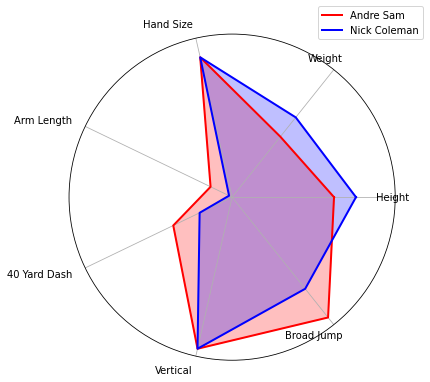

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from math import pi

# Load dataset
data = pd.read_csv('C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/db_sheet.csv')

fields_not_normalized = [
    'Height', 'Weight', 'Hand Size', 'Arm Length', 'Wonderlic', 
    '40 Yard Dash', 'Bench Press', 'Vertical', 'Broad Jump', 'Shuttle', 
    '3 Cone', '60Yd Shuttle'
]

# Invert the scale for fields where lower is better
invert_fields = ['40 Yard Dash', 'Shuttle', '3 Cone', '60Yd Shuttle']
large_fixed_number = 10  # Should be larger than any value in the fields

for field in invert_fields:
    data[field] = large_fixed_number - data[field]

player_name = input("Enter the name of the 2024 player to compare: ")
player_data = data[data['Draft Class'] == 2024]
player_row = player_data[player_data['Name'].str.lower() == player_name.lower()].iloc[0]

if player_row.empty:
    print("Player not found in the 2024 draft class. Please check the name and try again.")
else:
    # Find non-empty features for this player
    non_empty_features = [field for field in fields_not_normalized if not pd.isna(player_row[field])]
    
    # Filter out players missing any of these non-empty features
    data_filtered = data.dropna(subset=non_empty_features)
    
    # Calculate percentiles only for these features
    def calculate_percentiles(df, features):
        for feature in features:
            percentile_col_name = f'{feature} Percentile'
            df[percentile_col_name] = df[feature].rank(pct=True)
        return df

    data_filtered = calculate_percentiles(data_filtered, non_empty_features)
    
    # Normalize the feature values using StandardScaler
    scaler = StandardScaler()
    data_filtered[non_empty_features] = scaler.fit_transform(data_filtered[non_empty_features])

    data_2024_scaled = data_filtered[data_filtered['Draft Class'] == 2024]
    data_not_2024_scaled = data_filtered[data_filtered['Draft Class'] != 2024]

    # Calculate cosine similarity
    similarity = cosine_similarity(data_2024_scaled[non_empty_features], data_not_2024_scaled[non_empty_features])
    player_index = data_2024_scaled.index.get_loc(player_row.name)  # Get location in filtered data
    similarity_scores = similarity[player_index]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024_scaled.iloc[most_similar_index]['Name']
    
    print(f"The most similar player to {player_name} is {most_similar_player_name} with a similarity score of {similarity_scores[most_similar_index]:.2f}.")

    # Prepare data for the radar chart
    percentile_features = [f'{feature} Percentile' for feature in non_empty_features]
    player_percentiles = data_2024_scaled.loc[player_row.name, percentile_features]
    similar_player_percentiles = data_not_2024_scaled.iloc[most_similar_index][percentile_features]

    labels = np.array([feature.replace(' Percentile', '') for feature in percentile_features])
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 

    player_stats = player_percentiles.tolist() + player_percentiles.tolist()[:1]
    similar_player_stats = similar_player_percentiles.tolist() + similar_player_percentiles.tolist()[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, player_stats, color='red', alpha=0.25)
    ax.fill(angles, similar_player_stats, color='blue', alpha=0.25)
    ax.plot(angles, player_stats, color='red', linewidth=2, label=player_name)
    ax.plot(angles, similar_player_stats, color='blue', linewidth=2, label=most_similar_player_name)
    
    ax.set_xticks(angles[:-1])
    
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([])  # Removes radial gridlines

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()


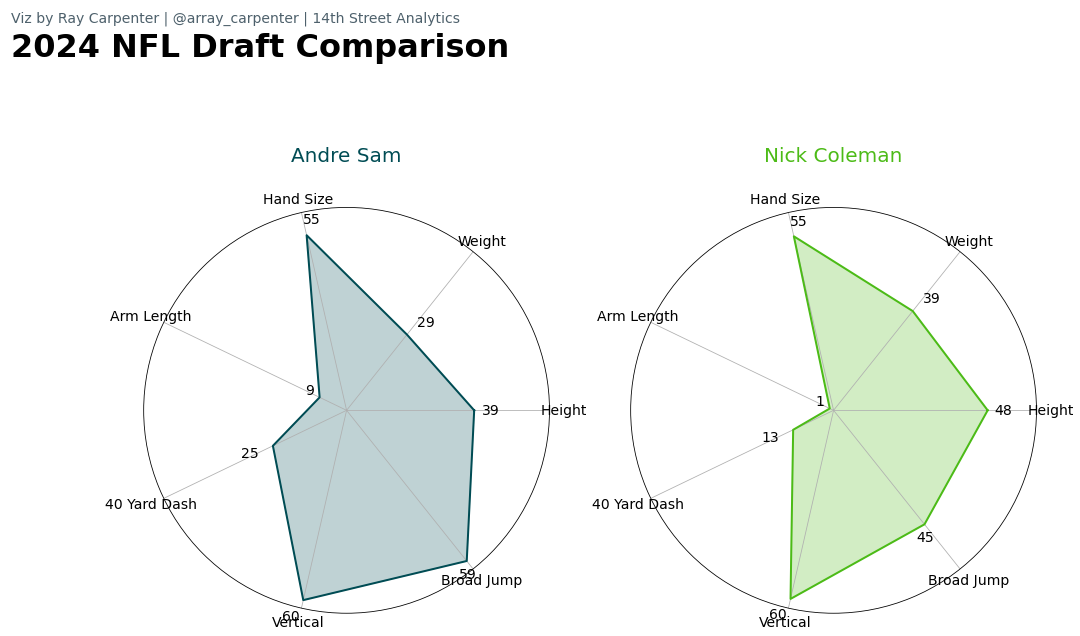

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from matplotlib.gridspec import GridSpec
from highlight_text import fig_text

def make_radar_chart(name, stats, feature_names, ax, fill_color, line_color):
    num_vars = len(feature_names)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    stats += stats[:1]
    angles += angles[:1]
    ax.fill(angles, stats, color=fill_color, alpha=0.25)
    ax.plot(angles, stats, color=line_color, linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names, fontsize=14)
    ax.set_title(name, size=20, color=line_color, y=1.1)
    for label, angle, stat in zip(feature_names, angles[:-1], stats[:-1]):
        ha = 'center' if angle in (0, pi) else 'left' if 0 < angle < pi else 'right'
        ax.text(angle, stat + 0.05, f"{int(stat*100)}", size=14, horizontalalignment=ha, verticalalignment="center")
    ax.set_yticks([])

# Creating a figure with a custom layout using GridSpec.
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = GridSpec(5, 2, fig)

# Allocating specific axes for the radar charts.
ax1 = fig.add_subplot(gs[1:, 0], polar=True)
ax2 = fig.add_subplot(gs[1:, 1], polar=True)

# Use fig_text or plt.text to add text in the reserved area.
fig_text(
    x=0.01, y=0.95, 
    s="2024 NFL Draft Comparison",
    va="top", ha="left",
    fontsize=32, color="black", weight="bold",
    fig=fig
)
fig_text(
    x=0.01, y=.98, 
    s="Viz by Ray Carpenter | @array_carpenter | 14th Street Analytics",
    va="top", ha="left",
    fontsize=14, color="#4E616C",
    fig=fig
)

player_color = '#004C54'
similar_player_color = '#4CBB17'


make_radar_chart(player_name, player_percentiles.tolist(), labels, ax1, fill_color=player_color, line_color=player_color)
make_radar_chart(most_similar_player_name, similar_player_percentiles.tolist(), labels, ax2, fill_color=similar_player_color, line_color=similar_player_color)

plt.show()


In [7]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import requests

import matplotlib.pyplot as plt
from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# grab the url from the src attribute of the embed code from fbref.com
url = "https://fbref.com/en/players/44bfb6c5/scout/10728/Ruben-Neves-Scouting-Report"

headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
pageTree = requests.get(url, headers=headers)
pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

# grab the data and put it in a DataFrame
df = pd.read_html(url, header=[1])[0]

#set stats values
Goals = df.iloc[0]['Percentile']
Assists = df.iloc[1]['Percentile']
Non_Penalty_Goals = df.iloc[2]['Percentile']
Penalty_Kicks_Made = df.iloc[3]['Percentile']
Penalty_Kicks_Attempted = df.iloc[4]['Percentile']
Yellow_Cards = df.iloc[5]['Percentile']
Red_Cards = df.iloc[6]['Percentile']
xG = df.iloc[8]['Percentile']
npxG = df.iloc[9]['Percentile']
xA = df.iloc[10]['Percentile']
npxG_xA = df.iloc[11]['Percentile']
Goals = df.iloc[14]['Percentile']
Shots_Total = df.iloc[15]['Percentile']
Shots_on_target = df.iloc[16]['Percentile']
Shots_on_target_Percent = df.iloc[17]['Percentile']
Goals_Shot = df.iloc[18]['Percentile']
Goals_Shot_on_target = df.iloc[19]['Percentile']
Average_Shot_Distance = df.iloc[20]['Percentile']
Shots_from_free_kicks = df.iloc[21]['Percentile']
Penalty_Kicks_Made = df.iloc[22]['Percentile']
Penalty_Kicks_Attempted = df.iloc[23]['Percentile']
xG = df.iloc[25]['Percentile']
npxG = df.iloc[26]['Percentile']
npxG_Sh = df.iloc[27]['Percentile']
Goals___xG = df.iloc[28]['Percentile']
Non_Penalty_Goals___npxG = df.iloc[29]['Percentile']
Passes_Completed = df.iloc[32]['Percentile']
Passes_Attempted = df.iloc[33]['Percentile']
Pass_Completion_Percent = df.iloc[34]['Percentile']
Total_Passing_Distance = df.iloc[35]['Percentile']
Progressive_Passing_Distance = df.iloc[36]['Percentile']
Passes_Completed_Short = df.iloc[38]['Percentile']
Passes_Attempted_Short = df.iloc[39]['Percentile']
Pass_Completion_Percent_Short = df.iloc[40]['Percentile']
Passes_Completed_Medium = df.iloc[42]['Percentile']
Passes_Attempted_Medium = df.iloc[43]['Percentile']
Pass_Completion_Percent_Medium = df.iloc[44]['Percentile']
Passes_Completed_Long = df.iloc[46]['Percentile']
Passes_Attempted_Long = df.iloc[47]['Percentile']
Pass_Completion_Percent_Long = df.iloc[48]['Percentile']
Assists = df.iloc[49]['Percentile']
xA = df.iloc[50]['Percentile']
Key_Passes = df.iloc[51]['Percentile']
Passes_into_Final_Third = df.iloc[52]['Percentile']
Passes_into_Penalty_Area = df.iloc[53]['Percentile']
Crosses_into_Penalty_Area = df.iloc[54]['Percentile']
Progressive_Passes = df.iloc[55]['Percentile']
Passes_Attempted = df.iloc[58]['Percentile']
Live_ball_passes = df.iloc[60]['Percentile']
Dead_ball_passes = df.iloc[61]['Percentile']
Passes_from_Free_Kicks = df.iloc[62]['Percentile']
Through_Balls = df.iloc[63]['Percentile']
Passes_Under_Pressure = df.iloc[64]['Percentile']
Switches = df.iloc[65]['Percentile']
Crosses = df.iloc[66]['Percentile']
Corner_Kicks = df.iloc[67]['Percentile']
Inswinging_Corner_Kicks = df.iloc[69]['Percentile']
Outswinging_Corner_Kicks = df.iloc[70]['Percentile']
Straight_Corner_Kicks = df.iloc[71]['Percentile']
Ground_passes = df.iloc[73]['Percentile']
Low_Passes = df.iloc[74]['Percentile']
High_Passes = df.iloc[75]['Percentile']
Passes_Attempted_Left = df.iloc[77]['Percentile']
Passes_Attempted_Right = df.iloc[78]['Percentile']
Passes_Attempted_Head = df.iloc[79]['Percentile']
Throw_Ins_taken = df.iloc[80]['Percentile']
Passes_Attempted_Other = df.iloc[81]['Percentile']
Passes_Completed = df.iloc[83]['Percentile']
Passes_Offside = df.iloc[84]['Percentile']
Passes_Out_of_Bounds = df.iloc[85]['Percentile']
Passes_Intercepted = df.iloc[86]['Percentile']
Passes_Blocked = df.iloc[87]['Percentile']
Shot_Creating_Actions = df.iloc[90]['Percentile']
SCA_PassLive = df.iloc[92]['Percentile']
SCA_PassDead = df.iloc[93]['Percentile']
SCA_Drib = df.iloc[94]['Percentile']
SCA_Sh = df.iloc[95]['Percentile']
SCA_Fld = df.iloc[96]['Percentile']
SCA_Def = df.iloc[97]['Percentile']
Goal_Creating_Actions = df.iloc[99]['Percentile']
GCA_PassLive = df.iloc[101]['Percentile']
GCA_PassDead = df.iloc[102]['Percentile']
GCA_Drib = df.iloc[103]['Percentile']
GCA_Sh = df.iloc[104]['Percentile']
GCA_Fld = df.iloc[105]['Percentile']
GCA_Def = df.iloc[106]['Percentile']
GCA_OG = df.iloc[107]['Percentile']
Tackles = df.iloc[110]['Percentile']
Tackles_Won = df.iloc[111]['Percentile']
Tackles_Def_3rd = df.iloc[112]['Percentile']
Tackles_Mid_3rd = df.iloc[113]['Percentile']
Tackles_Att_3rd = df.iloc[114]['Percentile']
Dribblers_Tackled = df.iloc[116]['Percentile']
Dribbles_Contested = df.iloc[117]['Percentile']
Percent_of_dribblers_tackled = df.iloc[118]['Percentile']
Dribbled_Past = df.iloc[119]['Percentile']
Pressures = df.iloc[121]['Percentile']
Successful_Pressures = df.iloc[122]['Percentile']
Successful_Pressure_Percent = df.iloc[123]['Percentile']
Pressures_Def_3rd = df.iloc[124]['Percentile']
Pressures_Mid_3rd = df.iloc[125]['Percentile']
Pressures_Att_3rd = df.iloc[126]['Percentile']
Blocks = df.iloc[128]['Percentile']
Shots_Blocked = df.iloc[129]['Percentile']
Shots_Saved = df.iloc[130]['Percentile']
Passes_Blocked = df.iloc[131]['Percentile']
Interceptions = df.iloc[133]['Percentile']
Tkl_Int = df.iloc[134]['Percentile']
Clearances = df.iloc[135]['Percentile']
Errors = df.iloc[136]['Percentile']
Touches = df.iloc[139]['Percentile']
Touches_Def_Pen = df.iloc[140]['Percentile']
Touches_Def_3rd = df.iloc[141]['Percentile']
Touches_Mid_3rd = df.iloc[142]['Percentile']
Touches_Att_3rd = df.iloc[143]['Percentile']
Touches_Att_Pen = df.iloc[144]['Percentile']
Touches_Live_Ball = df.iloc[145]['Percentile']
Dribbles_Completed = df.iloc[147]['Percentile']
Dribbles_Attempted = df.iloc[148]['Percentile']
Successful_Dribble_Percent = df.iloc[149]['Percentile']
Players_Dribbled_Past = df.iloc[150]['Percentile']
Nutmegs = df.iloc[151]['Percentile']
Carries = df.iloc[153]['Percentile']
Total_Carrying_Distance = df.iloc[154]['Percentile']
Progressive_Carrying_Distance = df.iloc[155]['Percentile']
Progressive_Carries = df.iloc[156]['Percentile']
Carries_into_Final_Third = df.iloc[157]['Percentile']
Carries_into_Penalty_Area = df.iloc[158]['Percentile']
Miscontrols = df.iloc[159]['Percentile']
Dispossessed = df.iloc[160]['Percentile']
Pass_Targets = df.iloc[162]['Percentile']
Passes_Received = df.iloc[163]['Percentile']
Passes_Received_Percent = df.iloc[164]['Percentile']
Progressive_Passes_Rec = df.iloc[165]['Percentile']
Yellow_Cards = df.iloc[168]['Percentile']
Red_Cards = df.iloc[169]['Percentile']
Second_Yellow_Card = df.iloc[170]['Percentile']
Fouls_Committed = df.iloc[171]['Percentile']
Fouls_Drawn = df.iloc[172]['Percentile']
Offsides = df.iloc[173]['Percentile']
Crosses = df.iloc[174]['Percentile']
Interceptions = df.iloc[176]['Percentile']
Tackles_Won = df.iloc[177]['Percentile']
Penalty_Kicks_Won = df.iloc[178]['Percentile']
Penalty_Kicks_Conceded = df.iloc[179]['Percentile']
Own_Goals = df.iloc[180]['Percentile']
Ball_Recoveries = df.iloc[181]['Percentile']
Aerials_won = df.iloc[183]['Percentile']
Aerials_lost = df.iloc[184]['Percentile']
Percent_of_Aerials_Won = df.iloc[185]['Percentile']

#save crabstats picture
crab_pic = "https://github.com/ohthatcrab/crabstats/blob/main/Crab%20Stats.png?raw=true"
cs_circ = Image.open(urlopen(crab_pic))

#load fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

#Compared against
vs_Position = pageSoup.find_all("a", {"class": "sr_preset"})
vs_Position = vs_Position[0].text.strip()

#player name
plr = pageSoup.find_all("h1", {"itemprop": "name"})
plr = plr[0].text.strip()

#birthdate
players_open = pageSoup.find('div', attrs={'id':'info'})
players_open_birth = players_open.find_all('span',{"itemprop": "birthDate"})
players_open_club = players_open.find_all("a")

if len(players_open_club) > 3:
    tm = players_open_club[2].text.strip()
else:
    tm = players_open_club[1].text.strip()
birthdate = players_open_birth[0].text.strip()

#set League and Year
stats_pullout = pageSoup.find('div', attrs={'class':'stats_pullout'})
stats_pullout_year = stats_pullout.find("h4")
stats_pullout_lg = stats_pullout.find_all("strong")
stats_pullout_min = stats_pullout.find_all("p")

sn = stats_pullout_year.text.strip()
lg = stats_pullout_lg[0].text.strip()

minvar = len(stats_pullout.find_all("strong"))*2
min_played = stats_pullout_min[minvar].text.strip()

# parameter list
params = ["Shots Total",
"npxG",
"xA",
"SCA (PassLive)",
"Passes into\nPenalty Area",
"Pass\nCompletion %",
"Progressive\nPasses",
"Passes into\nFinal Third",
"Progressive Carries",
"Dribbles\nCompleted",
"Pressures",
"Successful\nPressures",
"Tackles",
"Interceptions",
"Ball Recoveries"
]

# value list
# The values are taken from the excellent fbref website (supplied by StatsBomb)
values = [int(Shots_Total),
int(npxG),
int(xA),
int(SCA_PassLive),
int(Passes_into_Penalty_Area),
int(Pass_Completion_Percent),
int(Progressive_Passes),
int(Passes_into_Final_Third),
int(Progressive_Carries),
int(Dribbles_Completed),
int(Pressures),
int(Successful_Pressures),
int(Tackles),
int(Interceptions),
int(Ball_Recoveries)
]

# color for the slices and text
slice_colors = ["#000034"] * 5 + ["#696969"] * 5 + ["#720000"] * 5
text_colors = ["#F2F2F2"] * 15

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#EBEBE9",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=0,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-.",           # linestyle for other circles
    inner_circle_size=20            # size of inner circle
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(16, 17),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.3,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#F2F2F2", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=18,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.975, plr, size=35,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.953,
    "Percentile Rank vs Top-Five League " + vs_Position + " | Season " + sn,
    size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add credits
CREDIT_1 = "created by: @oh_that_crab"
CREDIT_2 = "data: StatsBomb via fbref"
CREDIT_3 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

fig.text(
    0.99, 0.02, f"{CREDIT_1}\n{CREDIT_2}\n{CREDIT_3}", size=17,
    fontproperties=font_italic.prop, color="#000000",
    ha="right"
)

# add playting infor
Info_1 = "Cur Club: " + tm
Info_2 = lg
Info_3 = "Minutes Played: " + min_played
Info_4 = "Born: " + birthdate

fig.text(
    0.02, 0.02, f"{Info_1}\n{Info_2}\n{Info_3}\n{Info_4}", size=25,
    color="#000000",
    ha="left"
)

# add text Attacking
fig.text(
    0.35, 0.925, "Attacking", size=20,
    fontproperties=font_bold.prop, color="#000000"
)
# add text Possession
fig.text(
    0.5, 0.925, "Possession", size=20,
    fontproperties=font_bold.prop, color="#000000"
)
# add text Possession
fig.text(
    0.67, 0.925, "Defending", size=20,
    fontproperties=font_bold.prop, color="#000000"
)

                               

# add rectangles
fig.patches.extend([
    plt.Rectangle(
        (0.31, 0.9225), 0.025, 0.021, fill=True, color="#000034",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.462, 0.9225), 0.025, 0.021, fill=True, color="#696969",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.632, 0.9225), 0.025, 0.021, fill=True, color="#720000",
        transform=fig.transFigure, figure=fig
    ),
])


# add image
ax_image = add_image(
    cs_circ, fig, left=0.4478, bottom=0.4385, width=0.13, height=0.13
)   # these values might differ when you are plotting


plt.savefig(plr + " - " + sn + ' '+ vs_Position + ' slice' +'.png')
plt.show()

IndexError: single positional indexer is out-of-bounds